In [1]:
import numpy as np
import scipy as sp
from itertools import combinations
import matplotlib.pyplot as plt

In [3]:
def generator_basis_set(tot_sites, N_e_up, N_e_down): # Tested OK
    spin_up_basis = []
    spin_down_basis = []

    for comb_up in combinations(range(tot_sites), N_e_up):
        state = [0] * tot_sites
        for idx in comb_up:
            state[idx] = 1
        spin_up_basis.append(state)

    for comb_down in combinations(range(tot_sites), N_e_down):
        state = [0] * tot_sites
        for idx in comb_down:
            state[idx] = 1
        spin_down_basis.append(state)

    basis = []

    for up_state in spin_up_basis:
        for down_state in spin_down_basis:
            basis.append([up_state, down_state])
    
    return np.array(basis)



def hop_j_2_k(input_state, j, k, spin): # Tested OK
    if input_state[spin][j] == 0 or input_state[spin][k] == 1:
        return 0, None
    
    state = input_state.copy()
    
    sign = 1

    # Destrying the particle

    for i in range(j):
        if state[spin][i] == 1:
            sign = sign * (-1)
    
    state[spin][j] = 0

    # Create the particle

    for i in range(k):
        if state[spin][i] == 1:
            sign = sign * (-1)
    
    state[spin][k] = 1

    return sign, state



def map_state_2_idx(basis_set): # Tested OK
    return {tuple(np.concatenate((state[0], state[1]))) : i for i, state in enumerate(basis_set)}



def generate_hamiltonian_matrix(basis_set, dim, tot_sites, U, J_1, J_11, J_3, J_33):

    state_2_idx_mapping = map_state_2_idx(basis_set)
    H = np.zeros((dim, dim))

    for a in range(dim):
        state = basis_set[a].copy()

        # Interaction Potential Energy

        for i in range(tot_sites):
            H[a, a] += U * state[0][i] * state[1][i]
        
        # Kinetic Energy

        for s in range(2):
            for j in range(tot_sites):
                for k in [j + 1, j - 1, j + 3, j - 3]:
                    if (k >= tot_sites) or (k < 0):
                        continue

                    hopped_state_sign, hopped_state = hop_j_2_k(state, j, k, s)
                    
                    if hopped_state_sign == 0:
                        continue

                    b = state_2_idx_mapping[tuple(np.concatenate((hopped_state[0], hopped_state[1])))]

                    # # Test Print
                    # print(state[0], state[1], '------', s, '---', hopped_state[0], hopped_state[1], '---', hopped_state_sign, '--', b + 1)

                    if j % 2 == 0: # Identifies site A

                        if k == j + 1:
                            H[a, b] -= J_11 * hopped_state_sign

                        elif k == j - 1:
                            H[a, b] -= J_1 * hopped_state_sign

                        elif k == j + 3:
                            H[a, b] -= J_33 * hopped_state_sign
                        
                        else:
                            H[a, b] -= J_3 * hopped_state_sign
                    
                    else: # Identifies site B
                        if k == j + 1:
                            H[a, b] -= J_1 * hopped_state_sign

                        elif k == j - 1:
                            H[a, b] -= J_11 * hopped_state_sign

                        elif k == j + 3:
                            H[a, b] -= J_3 * hopped_state_sign
                        
                        else:
                            H[a, b] -= J_33 * hopped_state_sign

    return H



def generate_n_matrix(basis_set, dim, site):
    n_matrix = np.zeros((dim, dim))

    for a in range(dim):
        n_matrix[a, a] = basis_set[a][0][site] + basis_set[a][1][site]
    
    return n_matrix



def generate_pos_sp_wf(state, basis_set, dim, tot_sites):
    pos_sp_state = np.zeros((2, tot_sites))

    for a in range(dim):
        pos_sp_state += basis_set[a] * state[a]

    return pos_sp_state



def generate_spin_coorelation(pos_sp_state, tot_sites):
    spin_coorelation_matrix = np.zeros((tot_sites, tot_sites))

    for j in range(tot_sites):
        for k in range(tot_sites):
            spin_coorelation_matrix[j, k] = (pos_sp_state[0][j] - pos_sp_state[1][j]) * (pos_sp_state[0][k] - pos_sp_state[1][k]) * 0.25
    
    return spin_coorelation_matrix


In [17]:
tot_sites = 8
N_e_up = tot_sites // 2
N_e_down = N_e_up
J_11 = 0.1
J_1 = 0.1
J_33 = 0.1
J_3 = 0.8
U = 10

In [18]:
basis_set = generator_basis_set(tot_sites, N_e_up, N_e_down)
dim = len(basis_set)

H = generate_hamiltonian_matrix(basis_set, dim, tot_sites, U, J_1, J_11, J_3, J_33)

# print(H)

# print(len(basis_set))
# print()
# print(basis_set)
# print(sp.linalg.ishermitian(H))

In [19]:
e_val, e_vec = np.linalg.eigh(H)

In [20]:
e_vec_pos_sp = np.zeros((dim, 2, tot_sites))

for a in range(dim):
    e_vec_pos_sp[a] = generate_pos_sp_wf(e_vec[a], basis_set, dim, tot_sites)

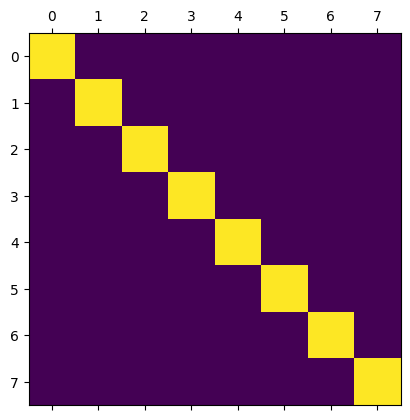

In [21]:
spin_coorelation_matrix = np.zeros((tot_sites, tot_sites))

for a in range(dim):
    spin_coorelation_matrix += generate_spin_coorelation(e_vec_pos_sp[a], tot_sites)

plt.matshow(spin_coorelation_matrix / dim)
plt.show()

In [13]:
n_av = np.zeros((tot_sites))

for site in range(tot_sites):
    n_site_matrix = generate_n_matrix(basis_set, dim, site)
    n_site_matrix_energy_basis = np.linalg.inv(e_vec) @ n_site_matrix @ e_vec

    for i in range(dim):
        n_av[site] += n_site_matrix_energy_basis[i, i]

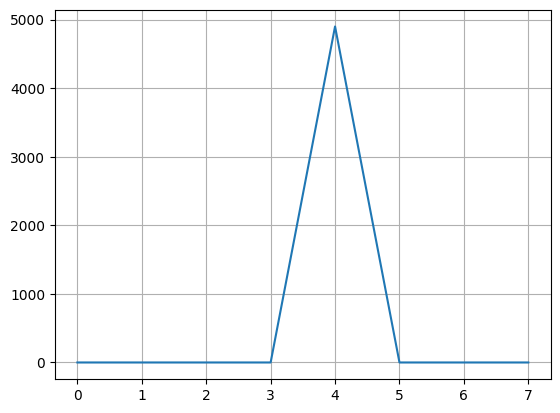

In [17]:
site = 4

n_av = np.zeros((tot_sites))

n_site_matrix = generate_n_matrix(basis_set, dim, site)
n_site_matrix_energy_basis = np.linalg.inv(e_vec) @ n_site_matrix @ e_vec

for i in range(dim):
    n_av[site] += n_site_matrix_energy_basis[i, i]

site_pos = np.arange(tot_sites)

plt.plot(site_pos, n_av)
plt.grid()
plt.show()

In [6]:
E = np.linalg.inv(e_vec) @ H @ e_vec

for i in range(dim):
    if np.round(E[i, i], decimals = 12) != np.round(e_val[i], decimals = 12):
        print(False)
        break

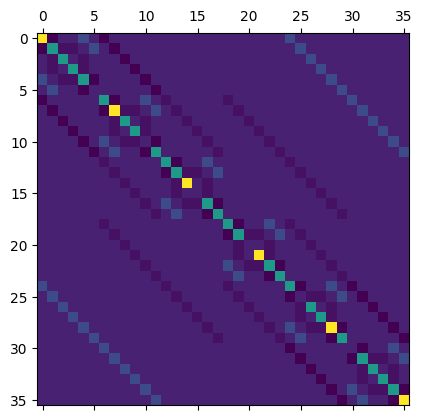

In [7]:
plt.matshow(H)
plt.show()

In [8]:
state_2_idx_mapping = map_state_2_idx(basis_set)

for key in state_2_idx_mapping:
    print(np.array(key[0: tot_sites]), np.array(key[tot_sites: 2 * tot_sites]), ' : ', state_2_idx_mapping[key])

[1 1 0 0] [1 1 0 0]  :  0
[1 1 0 0] [1 0 1 0]  :  1
[1 1 0 0] [1 0 0 1]  :  2
[1 1 0 0] [0 1 1 0]  :  3
[1 1 0 0] [0 1 0 1]  :  4
[1 1 0 0] [0 0 1 1]  :  5
[1 0 1 0] [1 1 0 0]  :  6
[1 0 1 0] [1 0 1 0]  :  7
[1 0 1 0] [1 0 0 1]  :  8
[1 0 1 0] [0 1 1 0]  :  9
[1 0 1 0] [0 1 0 1]  :  10
[1 0 1 0] [0 0 1 1]  :  11
[1 0 0 1] [1 1 0 0]  :  12
[1 0 0 1] [1 0 1 0]  :  13
[1 0 0 1] [1 0 0 1]  :  14
[1 0 0 1] [0 1 1 0]  :  15
[1 0 0 1] [0 1 0 1]  :  16
[1 0 0 1] [0 0 1 1]  :  17
[0 1 1 0] [1 1 0 0]  :  18
[0 1 1 0] [1 0 1 0]  :  19
[0 1 1 0] [1 0 0 1]  :  20
[0 1 1 0] [0 1 1 0]  :  21
[0 1 1 0] [0 1 0 1]  :  22
[0 1 1 0] [0 0 1 1]  :  23
[0 1 0 1] [1 1 0 0]  :  24
[0 1 0 1] [1 0 1 0]  :  25
[0 1 0 1] [1 0 0 1]  :  26
[0 1 0 1] [0 1 1 0]  :  27
[0 1 0 1] [0 1 0 1]  :  28
[0 1 0 1] [0 0 1 1]  :  29
[0 0 1 1] [1 1 0 0]  :  30
[0 0 1 1] [1 0 1 0]  :  31
[0 0 1 1] [1 0 0 1]  :  32
[0 0 1 1] [0 1 1 0]  :  33
[0 0 1 1] [0 1 0 1]  :  34
[0 0 1 1] [0 0 1 1]  :  35


In [9]:
j = 2
k = j + 3

state = basis_set[200]
spin = 1

hopped_state_sign, hopped_state = hop_j_2_k(state, j, k, spin)

print(state)
print(hopped_state_sign, '\n', hopped_state)

IndexError: index 200 is out of bounds for axis 0 with size 36